# English Premier League
The idea for this poject is simple. I am a fan of the English Premier league so I wanted to see if I could predict the scores of matches in the current season based on historical data.
I will begin by importing the necessary libraries.

In [1]:
# Import necessary libraries
import pandas as pd  # Pandas for data manipulation and analysis
from sklearn.model_selection import train_test_split  # For splitting the dataset into training and testing sets
from sklearn.linear_model import LinearRegression  # Linear regression model
from sklearn.metrics import mean_squared_error, r2_score  # Evaluation metrics for regression models
from sklearn.preprocessing import StandardScaler  # Standardize features by removing the mean and scaling to unit variance
from sklearn.tree import DecisionTreeRegressor  # Decision Tree regression model
import numpy as np  # NumPy for numerical operations
import requests  # For making HTTP requests
from bs4 import BeautifulSoup  # For web scraping
from io import StringIO  # For handling string as file-like objects
import lxml  # Parser for BeautifulSoup
import datetime  # For working with dates and times
pd.set_option('display.max_columns', 100)  # Set option to display max columns in Pandas
import seaborn as sns  # Seaborn for statistical data visualization
import matplotlib.pyplot as plt  # Matplotlib for plotting

# Grabbing the historical data from football-data.co.uk
Here I will import the historical data and do some data wrangling.
I will be grabbing the data from football-data.co.uk which has data on all premier league games going back to it's inception as a competition.

In [51]:
# Define the URL to fetch data from
url = "https://www.football-data.co.uk/englandm.php"

# Make an HTTP request to the specified URL
response = requests.get(url, verify=False)

# Lists to store extracted URLs and corresponding text
urls_list = []
text_list = []

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Parse the HTML content of the response
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find all tables in the HTML
    tables = soup.find_all('table')

    # Choose the 5th table if it exists
    target_table = tables[4] if len(tables) > 4 else None

    # Check if the target table exists
    if target_table:
        # Extract all hyperlinks (a tags) from the target table
        links = target_table.find_all('a')

        # Iterate over the links and extract href (URL) and text
        for link in links:
            href = link.get('href')
            text = link.get_text()
            urls_list.append(href)
            text_list.append(text)
    else:
        print("Table 5 not found on the page.")
else:
    print(f"Failed to fetch the webpage. Status code: {response.status_code}")

# List to store URLs of interest
data_urls = []

# Prefix to complete partial URLs
prefix = 'https://www.football-data.co.uk/'

# Iterate over the extracted text and URLs to filter out 'Premier League' URLs
for i, text in enumerate(text_list):
    if text == 'Premier League':
        data_urls.append(prefix + urls_list[i])

# Remove unnecessary URLs from the list
data_urls = data_urls[:-12]
data_urls = data_urls[1:]

# Create an empty DataFrame to store the data
df = pd.DataFrame()

# Iterate over the 'Premier League' URLs to fetch and process data
for url in data_urls:
    # Extract the season from the URL
    season = url.split('/')[4]
    print(f"Getting data for season {season}")

    # Read the CSV data from the URL into a temporary DataFrame
    temp_df = pd.read_csv(url)
    
    # Add a 'season' column to the temporary DataFrame
    temp_df['season'] = season

    # Process the 'Date' column to extract day, month, and year, and convert it to datetime
    temp_df = (temp_df.assign(Day=lambda df: df.Date.str.split('/').str[0],
                              Month=lambda df: df.Date.str.split('/').str[1],
                              Year=lambda df: df.Date.str.split('/').str[2])
                  .assign(Date=lambda df: pd.to_datetime(df.Date, format='mixed', dayfirst=True)))

    # Append the processed data to the main DataFrame
    df = df._append(temp_df, sort=True)

print("Finished grabbing data.")


c:\Users\New User\anaconda3\envs\conda_env\Lib\site-packages\urllib3\connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.football-data.co.uk'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Getting data for season 2223
Getting data for season 2122
Getting data for season 2021
Getting data for season 1920
Getting data for season 1819
Getting data for season 1718
Getting data for season 1617
Getting data for season 1516
Getting data for season 1415
Getting data for season 1314
Getting data for season 1213
Getting data for season 1112
Getting data for season 1011
Getting data for season 0910
Getting data for season 0809
Getting data for season 0708
Getting data for season 0607
Getting data for season 0506
Finished grabbing data.


I have managed to grab all my data from the webpage csv's and merge them all into one table.
Next I will do some cleaning up of the data.

In [10]:
# Create a new DataFrame 'epl_df' with selected columns from the original DataFrame 'df'
epl_df = df[['season',
             'Date',
             'Time',
             'Day',
             'Month',
             'Year',
             'HomeTeam',
             'AwayTeam',
             'FTHG',
             'FTAG',
             'FTR',
             'HTHG',
             'HTAG',
             'HTR',
             'Referee',
             'HS',
             'AS',
             'HST',
             'AST',
             'HF',
             'AF',
             'HC',
             'AC',
             'HY',
             'AY',
             'HR',
             'AR']].copy()

# Drop a specific row (index 380) from the DataFrame 'epl_df' that contains nulls
epl_df = epl_df.drop(index=380)

# Grabbing the current data from football-data.co.uk
Here I will import the current data for this year to compare it to my predictions later.

In [11]:
# Read data from a CSV file into a DataFrame
G_df_2324 = pd.read_csv('df_2324_season.csv')

# Create helpful columns like Day, Month, Year, Date, etc. for better data organization
G_df_2324 = G_df_2324.assign(
    Day=lambda df: G_df_2324['Date'].str.split('/').str[0],  # Extract day from the 'Date' column
    Month=lambda df: G_df_2324['Date'].str.split('/').str[1],  # Extract month from the 'Date' column
    Year=lambda df: G_df_2324['Date'].str.split('/').str[2]  # Extract year from the 'Date' column
)

# Convert the 'Date' column to a datetime format for consistency
G_df_2324['Date'] = pd.to_datetime(G_df_2324['Date'], format='%d/%m/%Y', dayfirst=True)

# Add a new column 'Season' with a value of 2324
G_df_2324['season'] = 2324

# Create a new DataFrame with selected columns for analysis
G_df_2324 = G_df_2324[[
 'season',
 'Date',
 'Time',
 'Day',
 'Month',
 'Year',
 'HomeTeam',
 'AwayTeam',
 'FTHG',
 'FTAG',
 'FTR',
 'HTHG',
 'HTAG',
 'HTR',
 'Referee',
 'HS',
 'AS',
 'HST',
 'AST',
 'HF',
 'AF',
 'HC',
 'AC',
 'HY',
 'AY',
 'HR',
 'AR'
]].copy()

# Create a new column 'Fixture' by combining 'HomeTeam' and 'AwayTeam'
epl_df['Fixture'] = epl_df['HomeTeam'] + ' vs ' + epl_df['AwayTeam']
G_df_2324['Fixture'] = G_df_2324['HomeTeam'] + ' vs ' + G_df_2324['AwayTeam']

# Create a new DataFrame 'Actual' with selected columns for actual match results
Actual = G_df_2324[[
 'season',  
 'Fixture',
 'FTHG',
 'FTAG'
]].copy()


# Data Prediction
Here I will attempt to predict the scores of matches for the current season.

In [12]:
# List of football teams for the 2023-2024 season
teams_2324 = [
    'Burnley', 'Arsenal', 'Bournemouth', 'Brighton', 'Everton', 'Sheffield United', 'Newcastle', 
    'Brentford', 'Chelsea', 'Man United', 'Nott\'m Forest', 'Fulham', 'Liverpool', 'Wolves', 
    'Tottenham', 'Man City', 'Aston Villa', 'West Ham', 'Crystal Palace', 'Luton'
]

# DataFrame to store predictions for all possible matchups
predictions_2324 = pd.DataFrame(columns=['HomeTeam', 'AwayTeam', 'PredictedFTHG', 'PredictedFTAG'])

# Loop through each home team
for home_team in teams_2324:
    # Loop through each away team
    for away_team in teams_2324:
        # Check if the home and away teams are different
        if home_team != away_team:
            # Extract historical match data for the current matchup
            match_data = epl_df[((epl_df['HomeTeam'] == home_team) & (epl_df['AwayTeam'] == away_team)) | 
                                 ((epl_df['HomeTeam'] == away_team) & (epl_df['AwayTeam'] == home_team))]

            # Check if there is enough historical data for the matchup
            if len(match_data) > 0:
                # Define features for the model
                features = ['HS', 'AS', 'HST', 'AST', 'HC', 'AC', 'HF', 'AF', 'HY', 'AY', 'HR', 'AR']
                # Extract input features (X) and output labels (y) for full-time goals for home and away teams
                X = match_data[features]
                y_fthg = match_data['FTHG']
                y_ftag = match_data['FTAG']

                # Standardize the input features
                scaler = StandardScaler()
                X_scaled = scaler.fit_transform(X)

                # Create separate models for predicting full-time goals for home and away teams
                model_fthg = DecisionTreeRegressor()
                model_ftag = DecisionTreeRegressor()

                # Train the models
                model_fthg.fit(X_scaled, y_fthg)
                model_ftag.fit(X_scaled, y_ftag)

                # Prepare data for predicting future match
                future_match_info = {'HS': 0, 'AS': 0, 'HST': 0, 'AST': 0, 'HC': 0, 'AC': 0, 'HF': 0, 'AF': 0, 'HY': 0, 'AY': 0, 'HR': 0, 'AR': 0}
                future_match = pd.DataFrame([future_match_info])
                future_match_scaled = scaler.transform(future_match)

                # Predict full-time goals for the future match
                predicted_fthg = model_fthg.predict(future_match_scaled).round().astype(int)
                predicted_ftag = model_ftag.predict(future_match_scaled).round().astype(int)

                # Ensure predicted goals are non-negative
                predicted_fthg = np.maximum(predicted_fthg, 0)
                predicted_ftag = np.maximum(predicted_ftag, 0)
            else:
                # If not enough historical data, set arbitrary values for predictions
                predicted_fthg = np.array([999])
                predicted_ftag = np.array([999])

            # Append predictions to the DataFrame
            predictions_2324 = predictions_2324._append({
                'HomeTeam': home_team,
                'AwayTeam': away_team,
                'PredictedFTHG': predicted_fthg[0],
                'PredictedFTAG': predicted_ftag[0]
            }, ignore_index=True)
        #else:
            # Print a message for matchups with insufficient historical data
           # print(f"Not enough historical data for {home_team} vs {away_team}")


# Create a new column 'Fixture' by combining 'HomeTeam' and 'AwayTeam'
predictions_2324['Fixture'] = predictions_2324['HomeTeam'] + ' vs ' + predictions_2324['AwayTeam']

# Add a new column 'Season' with a value of 2324
predictions_2324['season'] = 2324

# Create a new DataFrame 'Actual' with selected columns for actual match results
Predictions = predictions_2324[[
 'season',  
 'Fixture',
 'PredictedFTHG',
 'PredictedFTAG'
]].copy()


# Comparing Actual Data vs My Predictions
Here I will check to see how close the model got to the actual results.

In [25]:
# Merge dataframes on 'Fixture', keeping all rows from 'Actual' and dropping any games that havent happened yet.
merged_epl = pd.merge(Actual, Predictions[['Fixture', 'PredictedFTHG', 'PredictedFTAG']],
                     on='Fixture', how='left')

# Remove rows marked 999 which don't have enough historical data for comparison.

merged_epl[(merged_epl.PredictedFTAG != 999) | (merged_epl.PredictedFTHG != 999)]
# Display the updated merged dataframe
#print(merged_epl)


,season,Fixture,FTHG,FTAG,PredictedFTHG,PredictedFTAG
0,2324,Burnley vs Man City,0,3,3,0
1,2324,Arsenal vs Nott'm Forest,2,1,5,0
2,2324,Bournemouth vs West Ham,1,1,2,1
4,2324,Everton vs Fulham,0,1,1,1
5,2324,Sheffield United vs Crystal Palace,0,1,1,0
...,...,...,...,...,...,...
252,2324,Crystal Palace vs Burnley,3,0,1,0
253,2324,Man United vs Fulham,1,2,2,0
254,2324,Bournemouth vs Man City,0,1,3,1
255,2324,Arsenal vs Newcastle,4,1,2,2


As you can see my predictions weren't exactly perfect :)
I certainly wouldn't use this for my fantasy football league!

# Futher Analysis
Here I will take a look at other factors that might influence the model which I could add in later.

## Home Ground Advantage
Does playing at home give teams an advantage?

In [26]:
# Create Home Win, Draw Win and Away Win columns
epl_df['homeWin'] = np.where(epl_df['FTHG'] > epl_df['FTAG'], 1, 0)
epl_df['draw'] = np.where(epl_df['FTHG'] == epl_df['FTAG'], 1, 0)
epl_df['awayWin'] = np.where(epl_df['FTHG'] < epl_df['FTAG'], 1, 0)

win_rates = (epl_df.groupby('season')
    .agg({'homeWin': lambda x: pd.to_numeric(x, errors='coerce').mean(),
          'draw': lambda x: pd.to_numeric(x, errors='coerce').mean(),
          'awayWin': lambda x: pd.to_numeric(x, errors='coerce').mean()})
    .reset_index())

win_rates

,season,homeWin,draw,awayWin
0,0506,0.505263,0.202632,0.292105
1,0607,0.478947,0.257895,0.263158
2,0708,0.463158,0.263158,0.273684
3,0809,0.455263,0.255263,0.289474
4,0910,0.507895,0.252632,0.239474
5,1011,0.471053,0.292105,0.236842
6,1112,0.450000,0.244737,0.305263
7,1213,0.436842,0.284211,0.278947
8,1314,0.471053,0.205263,0.323684
9,1415,0.452632,0.244737,0.302632


## Charting Home Advantage

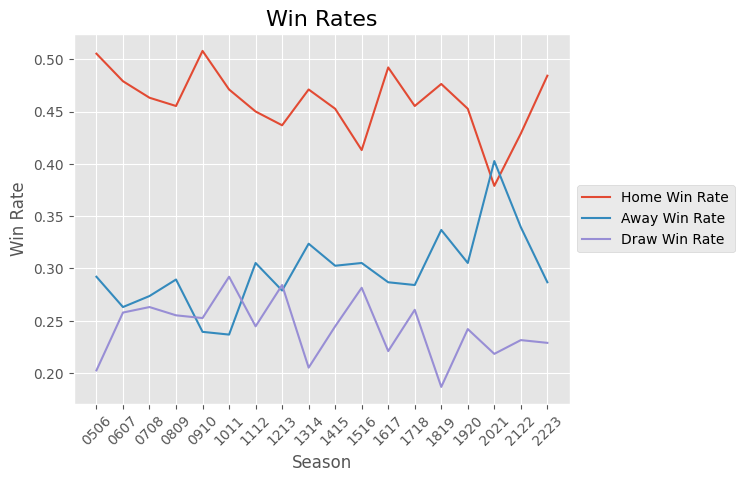

In [27]:
# Convert 'season' to categorical
win_rates['season'] = pd.Categorical(win_rates['season'], ordered=True)

plt.style.use('ggplot')
fig, ax = plt.subplots()

home_line = ax.plot(win_rates['season'], win_rates['homeWin'], label='Home Win Rate')
away_line = ax.plot(win_rates['season'], win_rates['awayWin'], label='Away Win Rate')
draw_line = ax.plot(win_rates['season'], win_rates['draw'], label='Draw Win Rate')

ax.set_xlabel("Season")
ax.set_ylabel("Win Rate")
plt.title("Win Rates", fontsize=16)
# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Add the legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

The dips between home and away in 21 was likely Covid when they played in front of no crowds.

In [28]:
# Which team had the biggest home ground advantage?
hga = (epl_df.groupby(['HomeTeam'])
         .agg(HGA=('homeWin', 'mean'))
         .reset_index()
         .rename(columns={'HGA': 'HGA'})
         .sort_values(by='HGA', ascending=False))

hga.head(10)

,HomeTeam,HGA
22,Man City,0.710526
23,Man United,0.695906
0,Arsenal,0.657895
21,Liverpool,0.654971
12,Chelsea,0.637427
36,Tottenham,0.611111
15,Everton,0.491228
20,Leicester,0.461988
7,Brentford,0.447368
3,Blackburn,0.443609


It looks like Overall Man City have the biggest Home Advantage

In [30]:
# Lets take a look at some of the big clubs.
big_clubs = ['Liverpool', 'Man City', 'Man United', 'Chelsea', 'Arsenal']
home_win_rates_5 = epl_df[epl_df.HomeTeam.isin(big_clubs)].groupby(['HomeTeam', 'season']).homeWin.mean()
away_win_rates_5 = epl_df[epl_df.AwayTeam.isin(big_clubs)].groupby(['AwayTeam', 'season']).awayWin.mean()

hga_top_5 = home_win_rates_5 - away_win_rates_5

hga_top_5.unstack(level=0)

HomeTeam,Arsenal,Chelsea,Liverpool,Man City,Man United
season,,,,,
0506,0.421053,0.368421,0.263158,0.263158,0.052632
0607,0.263158,0.000000,0.421053,-0.052632,0.105263
0708,0.210526,-0.052632,0.157895,0.368421,0.368421
0809,0.105263,-0.157895,-0.052632,0.578947,0.210526
0910,0.368421,0.368421,0.421053,0.315789,0.263158
1011,0.157895,0.368421,0.368421,0.263158,0.684211
1112,0.157895,0.315789,-0.105263,0.421053,0.105263
1213,0.052632,0.105263,0.105263,0.263158,0.210526
1314,0.105263,0.263158,0.315789,0.368421,-0.052632


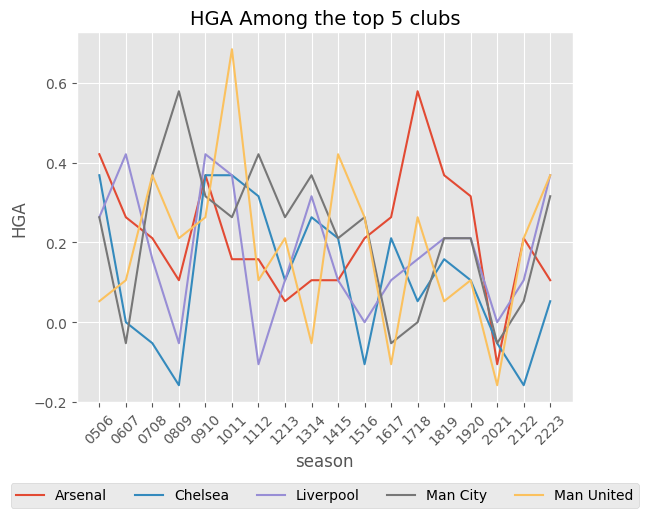

In [13]:
# Lets Plot it
sns.lineplot(x='season', y='HGA', hue='team', data=hga_top_5.reset_index().rename(columns={0: 'HGA', 'HomeTeam': 'team'}))
plt.legend(loc='upper center', ncol=6, bbox_to_anchor=(0.5, -0.2))
plt.title("HGA Among the top 5 clubs", fontsize=14)
plt.xticks(rotation=45)
plt.show()

Arsenal had a huge home game advantage for the 17/18 season. United has also in 10/11. It seems that some years this really favors a club.

## Referees
Lets see if any referees correlate with Home Ground Wins

In [31]:
#Print the average home win rate
print('Overall Home Win Rate: {:.4}%'.format(epl_df.homeWin.mean() * 100))

# Get the top 10 refs based on games
top_10_refs = epl_df.Referee.value_counts().head(10).index

epl_df[epl_df.Referee.isin(top_10_refs)].groupby('Referee').homeWin.mean().sort_values(ascending=False)

Overall Home Win Rate: 45.96%


Referee
L Mason          0.501742
M Clattenburg    0.478261
M Atkinson       0.460526
J Moss           0.459854
H Webb           0.458647
K Friend         0.455882
M Oliver         0.454286
M Dean           0.439076
A Taylor         0.436047
A Marriner       0.422680
Name: homeWin, dtype: float64

It looks like L Mason has reffed a lot of games where the home team wins.

# Comparing different variables
Lets create a margin to compare different variables against each other and see if they correlate.

In [32]:
# The margin will be Full Time Home Goals Minus Full Time Away Goals
epl_df['margin'] = epl_df['FTHG'] - epl_df['FTAG']

# Choosing Variables
stat_cols = ['AC', 'AF', 'AR', 'AS', 'AST', 'AY', 'HC', 'HF', 'HR', 'HS', 'HST', 'HY', 'margin']

# Checking variables against margin
stat_correlations = epl_df[stat_cols].corr()
stat_correlations['margin'].sort_values()

# Home Shots on Target correlate the most with Margin

AST      -0.366955
AS       -0.317376
HY       -0.151443
HR       -0.130426
AC       -0.085563
HF       -0.053894
AF        0.000905
AY        0.013539
HC        0.085870
AR        0.104450
HS        0.295481
HST       0.396923
margin    1.000000
Name: margin, dtype: float64

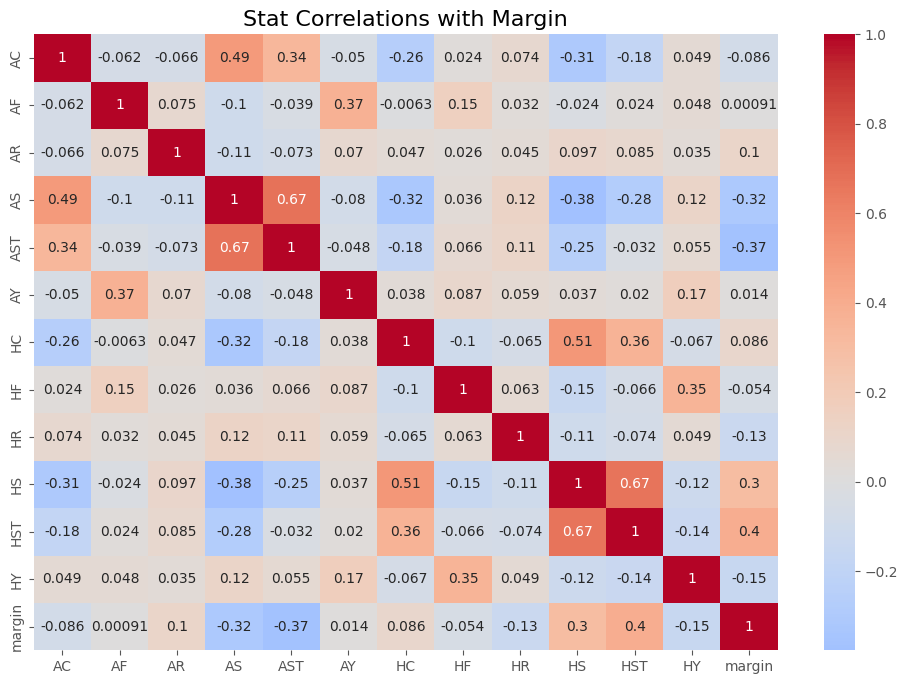

In [33]:
# Lets Plot the above to visually see
# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Plot the heatmap with the 'margin' in the middle
sns.heatmap(stat_correlations, annot=True, annot_kws={'size': 10}, cmap='coolwarm', center=0)

plt.title('Stat Correlations with Margin', fontsize=16)
plt.show()

As you can see Home Shots On Target correlate the most with the margin at 0.4. 
Interestingly Home Yellows Correlate one of the least at -0.1. Maybe teams play more agressively when they are losing and get booked?